In [1]:
import torch
import torch.nn as nn
import torch.utils.data as D
from torchvision.models import segmentation
from torchvision import transforms as T
import albumentations as A # Albumentations是一个用于图像增强和数据增强的Python库

import numpy as np
import pandas as pd
import time
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [2]:
# rle格式编码与解码函数
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [3]:
EPOCHES = 8  # 总的训练轮数
BATCH_SIZE = 64  # 每批次的样本数量
IMAGE_SIZE = 256  # 图像大小（宽度和高度均为256像素）
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # 使用GPU设备（如果可用），否则使用CPU

# 定义图像增强的转换列表
trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),  # 将图像调整为指定大小
    A.HorizontalFlip(p=0.5),  # 以50%的概率水平翻转图像
    A.VerticalFlip(p=0.5),  # 以50%的概率垂直翻转图像
    A.RandomRotate90(),  # 以随机90度旋转图像
])

In [4]:
class MyDataset(D.Dataset):
    def __init__(self, paths, rles, transform, test_mode=False):
        self.paths = paths  # 图像文件路径列表
        self.rles = rles    # 掩码（mask）的RLE编码列表
        self.transform = transform  # 图像增强的转换
        self.test_mode = test_mode  # 测试模式标志，用于区分训练和测试

        self.len = len(paths)  # 数据集的长度，即样本数量
        self.as_tensor = T.Compose([
            T.ToPILImage(),  # 转换为PIL图像
            T.Resize(IMAGE_SIZE),  # 调整图像大小
            T.ToTensor(),  # 转换为张量
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),  # 归一化
        ])

    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])  # 读取图像文件

        if not self.test_mode:
            mask = rle_decode(self.rles[index])  # 如果不是测试模式，解码RLE编码的掩码
            augments = self.transform(image=img, mask=mask)  # 应用图像增强
            return self.as_tensor(augments['image']), augments['mask'][None]  # 返回增强后的图像和掩码
        else:
            return self.as_tensor(img), ''  # 如果是测试模式，只返回增强后的图像，没有掩码

    def __len__(self):
        return self.len  # 返回数据集的长度，即样本数量

In [5]:
train_mask = pd.read_csv('datasets/train_mask.csv', sep='\t', names=['name', 'mask'])
train_mask['name'] = train_mask['name'].apply(lambda x: 'datasets/train/' + x)

img = cv2.imread(train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])

print(rle_encode(mask) == train_mask['mask'].iloc[0])

True


In [6]:
dataset = MyDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm, False
)

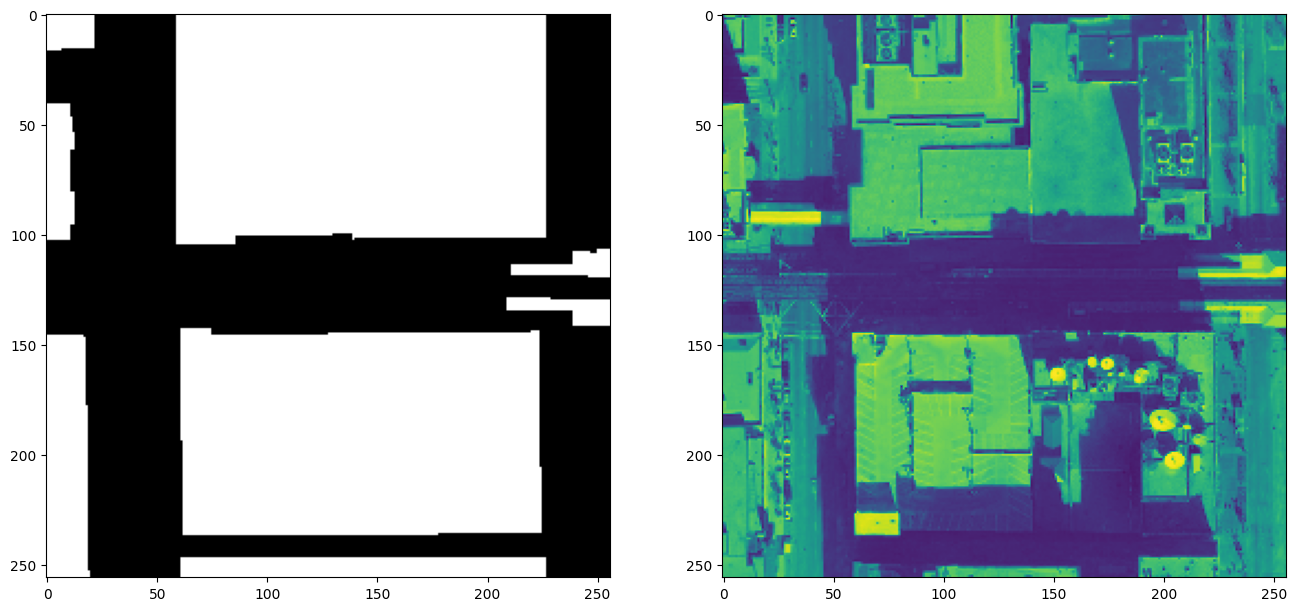

In [7]:
image, mask = dataset[0]
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0]);

In [8]:
shuffle_idx = np.arange(len(dataset))  # 创建一个索引数组，长度等于数据集的大小
np.random.shuffle(shuffle_idx)  # 随机打乱索引数组，用于随机化数据集

split_idx = int(0.75 * len(dataset))  # 计算训练集的分割点索引，将数据集分成训练集和验证集，这里使用了75%的数据作为训练集

train_idx = shuffle_idx[:split_idx]  # 使用打乱后的索引数组划分训练集
val_idx = shuffle_idx[split_idx:]  # 使用打乱后的索引数组划分验证集

train_ds = D.Subset(dataset, train_idx)  # 创建训练集的子集，包含训练集索引对应的样本
val_ds = D.Subset(dataset, val_idx)  # 创建验证集的子集，包含验证集索引对应的样本

train_loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)  # 创建训练数据加载器，指定批次大小、随机打乱数据以及使用的工作线程数

val_loader = D.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)  # 创建验证数据加载器，指定批次大小，不打乱验证数据，并使用的工作线程数

In [9]:
def get_model():
    model = segmentation.deeplabv3_resnet50(weights=segmentation.DeepLabV3_ResNet50_Weights)
    model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
    return model

@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

In [10]:
model = get_model()  # 创建一个神经网络模型
model.to(DEVICE)  # 将模型移动到指定的设备

optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)  # 创建AdamW优化器，用于模型参数的优化，指定学习率和权重衰减（L2正则化）

class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth  # 平滑项，用于防止分母为0
        self.dims = dims  # 维度元组，用于指定计算的维度
        
    def forward(self, x, y):
        tp = (x * y).sum(self.dims)  # 计算真正例的数量
        fp = (x * (1 - y)).sum(self.dims)  # 计算假正例的数量
        fn = ((1 - x) * y).sum(self.dims)  # 计算假负例的数量
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)  # 计算Soft Dice系数
        dc = dc.mean()  # 计算平均Soft Dice系数
        return 1 - dc  # 返回Soft Dice损失

bce_fn = nn.BCEWithLogitsLoss()  # 创建二进制交叉熵损失函数
dice_fn = SoftDiceLoss()  # 创建自定义的Soft Dice损失函数

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)  # 计算二进制交叉熵损失
    dice = dice_fn(y_pred.sigmoid(), y_true)  # 计算Soft Dice损失
    return 0.8 * bce + 0.2 * dice  # 返回加权的总损失，以0.8倍的二进制交叉熵和0.2倍的Soft Dice

In [11]:
# 可视化训练过程中的损失和准确率
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.savefig('Accuracy and loss curve.png')
    plt.show()

In [12]:
train_losses = []  # 用于存储训练过程中的损失值
val_losses = []    # 用于存储验证过程中的损失值
train_accuracies = []  # 用于存储训练过程中的准确率
val_accuracies = []    # 用于存储验证过程中的准确率

best_loss = 10  # 初始化最佳验证损失值为一个较大的数值
best_accuracy = 0  # 初始化最佳验证准确率为0

# 循环训练多个轮次（epoch）
for epoch in range(1, EPOCHES + 1):
    model.train()  # 设置模型为训练模式
    start = time.time()  # 记录训练开始的时间
    total_correct = 0  # 初始化总正确预测数量
    total_samples = 0  # 初始化总样本数量

    # 遍历训练数据加载器中的批次数据
    for image, target in tqdm(train_loader):
        image, target = image.to(DEVICE), target.float().to(DEVICE)  # 将图像和目标移到指定设备上
        optimizer.zero_grad()  # 清零优化器的梯度
        output = model(image)['out']  # 使用模型进行前向传播
        loss = loss_fn(output, target)  # 计算损失
        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 更新模型参数
        train_losses.append(loss.item())  # 记录训练损失值
        
        predicted = (output.sigmoid() > 0.5).float()  # 阈值处理模型输出，得到二进制预测结果
        total_correct += (predicted == target).sum().item()  # 统计正确预测的数量
        total_samples += target.numel()  # 统计样本数量

        train_losses = []  # 清空训练损失列表

    train_accuracy = total_correct / total_samples  # 计算训练准确率
    train_accuracies.append(train_accuracy)  # 记录训练准确率

    val_loss = validation(model, val_loader, loss_fn)  # 调用validation函数计算验证损失
    val_losses.append(val_loss)  # 记录验证损失

    # 计算验证集准确率
    model.eval()  # 设置模型为评估模式
    total_correct = 0
    total_samples = 0
    for image, target in tqdm(val_loader):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        predicted = (output.sigmoid() > 0.5).float()
        total_correct += (predicted == target).sum().item()
        total_samples += target.numel()

    val_accuracy = total_correct / total_samples
    val_accuracies.append(val_accuracy)

    # 打印当前轮次的训练和验证信息
    print(
        f"Epoch [{epoch}/{EPOCHES}] | Train Loss: {np.mean(train_losses):.4f} | Train Accuracy: {train_accuracy * 100:.2f}% | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy * 100:.2f}% | Time:{((time.time()-start) / 60):.2f}min")

    # 如果当前轮次的验证损失优于之前记录的最佳验证损失，则保存模型参数
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'model_best.pth')

    # 如果当前轮次的验证准确率优于之前记录的最佳验证准确率，则更新最佳验证准确率
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [1/8] | Train Loss: 0.3290 | Train Accuracy: 90.91% | Validation Loss: 0.2369 | Validation Accuracy: 94.24% | Time:23.33min


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [2/8] | Train Loss: 0.2192 | Train Accuracy: 94.43% | Validation Loss: 0.2004 | Validation Accuracy: 94.77% | Time:23.63min


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [3/8] | Train Loss: 0.1933 | Train Accuracy: 94.90% | Validation Loss: 0.1850 | Validation Accuracy: 95.07% | Time:24.57min


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [4/8] | Train Loss: 0.1802 | Train Accuracy: 95.20% | Validation Loss: 0.1758 | Validation Accuracy: 95.27% | Time:23.65min


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [5/8] | Train Loss: 0.1717 | Train Accuracy: 95.30% | Validation Loss: 0.1709 | Validation Accuracy: 95.19% | Time:23.40min


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [6/8] | Train Loss: 0.1493 | Train Accuracy: 95.39% | Validation Loss: 0.1453 | Validation Accuracy: 95.33% | Time:23.27min


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [7/8] | Train Loss: 0.1422 | Train Accuracy: 95.45% | Validation Loss: 0.1420 | Validation Accuracy: 95.41% | Time:22.75min


  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [8/8] | Train Loss: 0.1367 | Train Accuracy: 95.55% | Validation Loss: 0.1386 | Validation Accuracy: 95.52% | Time:23.52min


In [ ]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [14]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

submit = []

model.load_state_dict(torch.load("./model_best.pth")) # 加载最佳模型
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [15]:
# 从CSV文件中读取测试集的样本提交文件，使用制表符分隔，设置列名为'name'和'mask'
test_mask = pd.read_csv('datasets/test_a_samplesubmit.csv', sep='\t', names=['name', 'mask'])

# 对'name'列中的文件路径进行处理，添加前缀'datasets/test_a/'，以便加载测试集图像
test_mask['name'] = test_mask['name'].apply(lambda x: 'datasets/test_a/' + x)

# 创建一个空列表submit，用于存储测试集的提交结果
submit = []

# 遍历测试集中的每个样本
for idx, name in enumerate(tqdm(test_mask['name'].iloc[:])):
    image = cv2.imread(name)  # 读取测试集中的图像文件
    image = trfm(image)  # 对图像应用图像增强

    with torch.no_grad():
        image = image.to(DEVICE)[None]  # 将图像移到指定的设备上并添加批次维度
        score = model(image)['out'][0][0]  # 使用模型进行前向传播
        score_sigmoid = score.sigmoid().cpu().numpy() 
        score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)  # 根据阈值将概率分布转换为0，1分布
        score_sigmoid = cv2.resize(score_sigmoid, (512, 512))  # 调整图像大小为512x512像素

    # 将结果添加到submit列表中，包括文件名和RLE编码的分割掩码
    submit.append([name.split('/')[-1], rle_encode(score_sigmoid)])

  0%|          | 0/2500 [00:00<?, ?it/s]

In [16]:
submit = pd.DataFrame(submit)
submit.to_csv('./submission.csv', index=None, header=None, sep='\t')

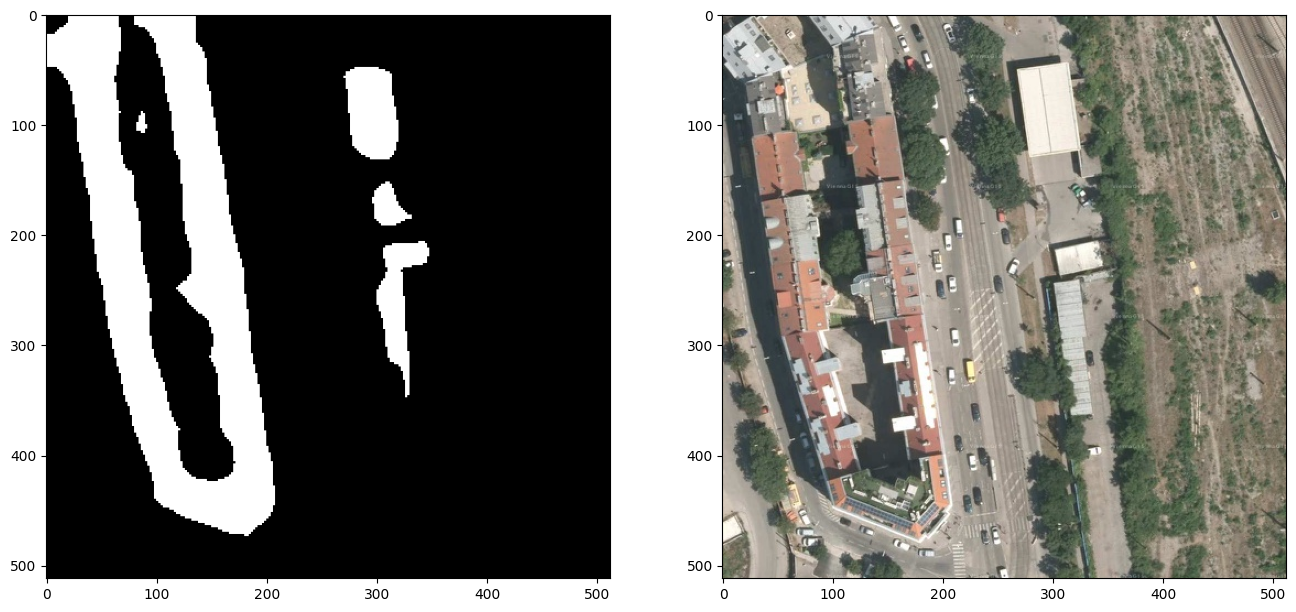

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(rle_decode(submit[1].fillna('').iloc[0]), cmap='gray')
plt.subplot(122)
plt.imshow(cv2.imread('datasets/test_a/' + submit[0].iloc[0]));